# **Importing Packages**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# **Pre-Processing Data**

In [2]:
# Converting the Matching Pennies Data into a CSV file
MP_txt = r"/content/MPbehdata.out" #location of the txt file
MP_csv = r"/content/MPbehdata.csv" #location of the new csv file
#read the data frame using a space to separatem setting index_col to false so that the first column does not turn into the index
MP_df = pd.read_csv(MP_txt, delimiter=' ', skiprows=1, names=['Animal ID', 'Algorithm', 'Session', 'Computer Choice', 'Monkey Choice', 'Reward'],index_col = False) #readining the file into a data frape, and separate values
MP_df.to_csv(MP_csv, index=False)
MP_df.dropna(inplace = True) #dropping any rows with missing values

In [3]:
MP_df #printing the data frame

,Animal ID,Algorithm,Session,Computer Choice,Monkey Choice,Reward
0,13,0,1,0,0,1
1,13,0,1,1,0,0
2,13,0,1,0,0,1
3,13,0,1,1,0,0
4,13,0,1,0,1,0
...,...,...,...,...,...,...
279830,112,2,23,1,0,0
279831,112,2,23,0,0,1
279832,112,2,23,0,1,0
279833,112,2,23,0,0,1


In [4]:
MP_df.columns #checking to make sure the columns are corrext

Index(['Animal ID', 'Algorithm', 'Session', 'Computer Choice', 'Monkey Choice',
       'Reward'],
      dtype='object')

In [5]:
MP_df.head() #checking to ensure that the data appears to be in the proper format

,Animal ID,Algorithm,Session,Computer Choice,Monkey Choice,Reward
0,13,0,1,0,0,1
1,13,0,1,1,0,0
2,13,0,1,0,0,1
3,13,0,1,1,0,0
4,13,0,1,0,1,0


In [6]:
#We only are interested in the data in which the algorithm = 0, so we filter out all of the other algorithms
#We also need to make sure to separate this for each monkey. Additionally, we will need to loop through each session.

#When testing for generalization, I changed the Animal ID to see how the model performed with each monkey
MP_algo2 = MP_df[(MP_df['Algorithm'] == 0) & (MP_df['Animal ID'] == 13)] #Monkey ID's: 13, 18, 112

#By inspecting the data, we can see how many trials the monkey completed under any specefic algorithm
MP_algo2


,Animal ID,Algorithm,Session,Computer Choice,Monkey Choice,Reward
0,13,0,1,0,0,1
1,13,0,1,1,0,0
2,13,0,1,0,0,1
3,13,0,1,1,0,0
4,13,0,1,0,1,0
...,...,...,...,...,...,...
5321,13,0,2,1,1,1
5322,13,0,2,0,1,0
5323,13,0,2,1,0,0
5324,13,0,2,0,1,0


In [7]:
#For some reason, Monkey ID and Algorithm were getting factored in as features, so here I removed them from the DF
MP_algo2 = MP_algo2[['Session', 'Computer Choice', 'Monkey Choice', 'Reward']]

In [8]:

count = len(MP_algo2[MP_algo2['Monkey Choice'] == 1])
print(count)

right_target_count = count/len(MP_algo2)
print(right_target_count)

3730
0.7003379647014645


In [9]:
print(MP_algo2) #ensuring that those two columns were indeed removed

      Session  Computer Choice  Monkey Choice  Reward
0           1                0              0       1
1           1                1              0       0
2           1                0              0       1
3           1                1              0       0
4           1                0              1       0
...       ...              ...            ...     ...
5321        2                1              1       1
5322        2                0              1       0
5323        2                1              0       0
5324        2                0              1       0
5325        2                1              1       1

[5326 rows x 4 columns]


# **Move Prediction**
- resource: https://www.kaggle.com/code/kmkarakaya/lstm-understanding-the-number-of-parameters
- Training across all sessions for one monkey, and generalizability will be tested by using the data from the other **monkeys**
- LSTM model with an adam optimizer

In [10]:
#Since the data was collected over many days, it is important to group the data by session
#For example we done want a choice the monkey made on Friday, to be used to predict a choice the monkey made on Monday
grouped = MP_algo2.groupby('Session')

#Defining Columns for our sequence below
target_column = 'Monkey Choice'
session_column = 'Session'
reward_column = 'Reward'

In [11]:
# Extract features and target
features = MP_algo2[['Computer Choice', 'Monkey Choice', 'Reward']].values #we are using the data from the computer choice and monkey choice
target = MP_algo2['Monkey Choice'].values  # Predicting the monkey's next move using the features specified above

In [11]:
print(MP_algo2)

      Session  Computer Choice  Monkey Choice  Reward
0           1                0              0       1
1           1                1              0       0
2           1                0              0       1
3           1                1              0       0
4           1                0              1       0
...       ...              ...            ...     ...
5321        2                1              1       1
5322        2                0              1       0
5323        2                1              0       0
5324        2                0              1       0
5325        2                1              1       1

[5326 rows x 4 columns]


In [12]:
print(features.shape) #ensuring that I have the correct number of features

(5326, 3)


In [13]:
#creating a sequence that will group the sessions

def create_sequences(MP_algo2, target_column, session_column, num_prior_moves):
    X, y = [], []
    grouped = MP_algo2.groupby(session_column)  # group by session. This ensures that we are predicting moves that occured on the same day

    for session, group in grouped:
        # Extract features and targets for each current session
        features = group[['Computer Choice', 'Monkey Choice', 'Reward']].values #specifying which columns are features
        targets = group[target_column].values #monkey choice is the target since that is what I am predicting

        # Ensure sequence creation only if enough data is available
        if len(features) > num_prior_moves:
            for i in range(len(features) - num_prior_moves):
                X.append(features[i:i+num_prior_moves])  # Features for sequence
                y.append(targets[i+num_prior_moves])    # Target for next step

    return np.array(X), np.array(y)


In [14]:
#Seems like the features are one hot encoded
print(features)

[[0 0 1]
 [1 0 0]
 [0 0 1]
 ...
 [1 0 0]
 [0 1 0]
 [1 1 1]]


In [15]:
# Set sequence length
#I tested many different values for this parameter to see which yielded the highest accuracy
num_prior_moves = 5 # Number of previous moves to consider for the prediction

# Create sequences
X, y = create_sequences(MP_algo2, target_column, session_column, num_prior_moves)


In [16]:
print(features.shape)

(5326, 3)


In [16]:
#80:20 training and testing split, choosing a random_state to randomly separate the data into this split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Define model parameters
timesteps = num_prior_moves #the previous 5 moves will be considered for the prediction
#Number of features: (computer choice, monkey choice, reward)
LSTMoutputDimension = 200 # Starting with 50 and will tweak depending on overfitting/underfitting. Since the model
#did not yield a particiularly high accuracy with 50, I continously increased by 50 dimensions until I got a better accuracy


In [18]:
# Check the shape of X_train
print("The shape of X_train is: ", X_train.shape)
#  y_train needs to be a 1D array with shape (None, 1).w I was getting an error message when I ran my model so I had to add this
y_train = y_train.reshape(-1, 1)
#I also had to reshape X_train to avoid the error
X_train = np.expand_dims(X_train, axis=-1)



The shape of X_train is:  (4252, 5, 3)


In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define LSTM Model
input = Input(shape=(X_train.shape[1], X_train.shape[2]))  # Define the input layer
lstm_out = LSTM(LSTMoutputDimension, activation = 'relu')(input)
dropout_out = Dropout(0)(lstm_out)  # Tested varying percentages of droput, but then decided not to use it
dense1 = Dense(64, activation='relu')(dropout_out)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(32, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(1, activation='sigmoid')(dropout_out)  # Final output layer for binary classification

# Create the model mapping input to output
model_LSTM = Model(inputs=input, outputs=output)

# Define the optimizer with a specified learning rate
learning_rate = 0.007
adam_optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model_LSTM.compile(optimizer= adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model_LSTM.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 5, 3)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 200)                 │         163,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 163,401 (638.29 KB)

 Trainable params: 163,401 (638.29 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
#Calcylating the sizes of each weight matrix and bias vector from the model
# LSTM parameter number = 4 × (( 𝑥 +  ℎ) ×  ℎ + ℎ)
W = model_LSTM.layers[1].get_weights()[0]
U = model_LSTM.layers[1].get_weights()[1]
b = model_LSTM.layers[1].get_weights()[2]
print("Total Parameter Number: 4 × ((x + h) × h +h) " ,
      4* ((features+LSTMoutputDimension)*LSTMoutputDimension+LSTMoutputDimension))

Total Parameter Number: 4 × ((x + h) × h +h)  [[160800 160800 161600]
 [161600 160800 160800]
 [160800 160800 161600]
 ...
 [161600 160800 160800]
 [160800 161600 160800]
 [161600 161600 161600]]


In [20]:
# Train the model
#After training the model, with 50 dimensions, accuracy is falling intop the 50-60% range so there is room for improvement
#I will tune the hyperparameters in an attempt to improve the accuracy before evaluating the model
history = model_LSTM.fit(X_train, y_train, epochs= 50, batch_size=32, validation_split=0.2)



Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7105 - loss: 0.5802 - val_accuracy: 0.7086 - val_loss: 0.5398
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7232 - loss: 0.5382 - val_accuracy: 0.7168 - val_loss: 0.5617
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7332 - loss: 0.5172 - val_accuracy: 0.7145 - val_loss: 0.5418
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7334 - loss: 0.5381 - val_accuracy: 0.7098 - val_loss: 0.5384
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7224 - loss: 0.5404 - val_accuracy: 0.7074 - val_loss: 0.5375
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7326 - loss: 0.5270 - val_accuracy: 0.7098 - val_loss: 0.5373
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7340 - loss: 0.5210 - val_accuracy: 0.7109 - val_loss: 0.5389
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7362 - loss: 0.5261 - val_accu

In [21]:
#Now that I have trained the model I can take a look at the predictions using X_test
prediction_probability = model_LSTM.predict(X_test)

#Since I used a signmoid activation in the last layer the results printed are the probabilities
print(prediction_probability[:5])

# Convert probabilities to binary predictions (0 or 1) Left or Right Target
target_predictions = (prediction_probability > 0.5).astype(int)
print(target_predictions[:10])
print(y_test[:10])


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[[0.9073041 ]
 [0.4229499 ]
 [0.44389752]
 [0.740762  ]
 [0.63093024]]
[[1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]]
[1 1 0 1 1 1 0 0 1 1]


# **Behavior Before and After Reward**

Using the model I created above. I can look into different aspects of the monkey's behavior during the game. One area of interest is how reward affects move choice. These results indicate that the Monkey's tend to repeat choices after receiving a reward.

In [22]:
#I want to define a function that calculates the liklihood that the monkey will repeat the same move after reward
def extract_repeated_choices_after_reward(data, reward_column_index=2, choice_column_index=1): #in my features list, monkey choice is in index 1, reward is in index 2
    # extract the reward column
    rewards = data[:, reward_column_index]

    # find instances where reward is given (reward = 1)
    reward_indices = np.where(rewards == 1)[0]

    repeated_choices = [] #creating an empty list to store the indices

    # loop over indices where the monkey received a reward
    for index in reward_indices:
        # Ensure we have a next choice available (making sure it is not the last move in the sequence)
        if index + 1 < len(rewards):
            current_choice = data[index + 1, choice_column_index]  # monkey Choice after reward
            if index + 2 < len(rewards):
                next_choice = data[index + 2, choice_column_index]  # monkey Choice two steps after reward
                if current_choice == next_choice:
                    repeated_choices.append(current_choice)

    return repeated_choices

# See how many times the monkey repeated a choice after a reward
repeated_choices_after_reward = extract_repeated_choices_after_reward(features, reward_column_index=2)

# Count how many times the same choice is repeated after reward
count_repeated = len(repeated_choices_after_reward) #number of times the monkey repeated his choice after receiving a reward
total_rewards = np.sum(features[:, 2] == 1) #total number of trials in which the monkey received reward

print(f"Total rewards: {total_rewards}")
print(f"Count of repeated choices after rewards: {count_repeated}")
print(f"Percentage of repeated choices: {count_repeated / total_rewards * 100:.2f}%") #Calculating the percentage


Total rewards: 2646
Count of repeated choices after rewards: 1656
Percentage of repeated choices: 62.59%


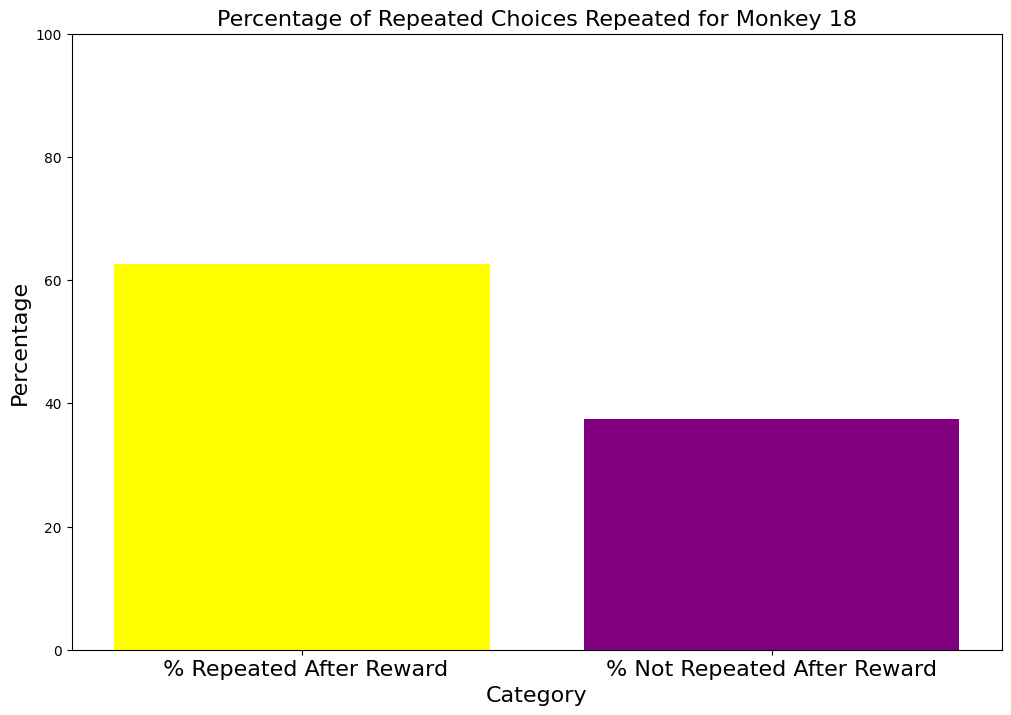

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8)) #enlarging the size of the figure to make sure the text is visable on the plot

categories = [' % Repeated After Reward', '% Not Repeated After Reward'] #labels for the two bars
before_reward_percentage = count_repeated / total_rewards * 100 #calculating the percentage of moves that were repeated after reward
after_reward_percentage = 100 - before_reward_percentage #calculating the percentage of moves that were not repeated after reward
percentages = [before_reward_percentage, after_reward_percentage]

plt.bar(categories, percentages, color=['yellow', 'purple']) #plotting the categories on the x-axis, and the percentage on the y
plt.ylabel('Percentage', fontdict={'fontsize': 16}) #labeling the y axis and specifying the size
plt.xlabel('Category', fontdict={'fontsize': 16}) #labeling the x axis and specifying the size
plt.tick_params(axis='x', labelsize=16) #changing the size of the category names
plt.title('Percentage of Repeated Choices Repeated for Monkey 18', fontdict = {'fontsize': 16}) #setting a title and changing the size
plt.ylim(0, 100) #changing the range of the x axis
plt.show() #visualizing the plot


## **Model Evaluation**

In order to evaluate the model, I will be using time series cross validation, precision, accuracy, recall, and F-score. The results are as follows:

Monkey 112:
Monkey 13:
Monkey 18:


In [26]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

In [29]:
# Calculate precision, recall, F-score, and support

#The values of the predicted values and the target values were not equal, so the function wouldnt run
#here i am indexing the first 879 values of the actual data so that I ca compare to the predicted data
y_test2 = y_test

precision, recall, fscore, support = precision_recall_fscore_support(
    y_test2, target_predictions, #The two that I am comparing
    beta=1.0,
    labels=None,
    pos_label=1,
    average='binary',  #two categories, so I will use binary
    warn_for=('precision', 'recall', 'f-score'),
    sample_weight=None,
    zero_division='warn'
)

print("Precision:", precision)
print("Recall:", recall)
print("F-score:", fscore)

Precision: 0.7557251908396947
Recall: 0.8342696629213483
F-score: 0.7930574098798397


In [30]:
#Accuracy
accuracy = accuracy_score(y_test2, target_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7086466165413534


In [31]:
#Time Series Cross Validation

X = np.array(X)
y = np.array(y)
tscv = TimeSeriesSplit(n_splits=3)
print(tscv)
for train, test in tscv.split(X):
    print("%s %s" % (train, test))


TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None)
[   0    1    2 ... 1326 1327 1328] [1329 1330 1331 ... 2655 2656 2657]
[   0    1    2 ... 2655 2656 2657] [2658 2659 2660 ... 3984 3985 3986]
[   0    1    2 ... 3984 3985 3986] [3987 3988 3989 ... 5313 5314 5315]


In [32]:
#Was getting an error, so I wanted to ensure that X_train and X_test had the correct shape
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (4252, 5, 3, 1)
X_test shape: (1064, 5, 3)


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Initialize lists to store predictions and errors
predictions = []
errors = []

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=3) #splitting the data into 3

#loops through each time series fold
for train_index, test_index in tscv.split(X): #splits the data into train/test splits while maintaining temporal order
    X_train, X_test = X[train_index], X[test_index] #training and testing features
    y_train, y_test = y[train_index], y[test_index] #training and testing target

    # Reshaping the data to match the LSTM's expected input shape
    X_train = X_train.reshape((X_train.shape[0], 5, 3))  # 5 time steps, 3 features
    X_test = X_test.reshape((X_test.shape[0], 5, 3))    # 5 time steps, 3 features

    # Reinitialize the model before each fold of Time Series Cross-Validation using the same hyper parameters that
    #were used in the original trained model
    model_LSTM = Sequential()
    model_LSTM.add(LSTM(200, input_shape=(5, 3), activation='relu'))
    model_LSTM.add(Dropout(0))  #matching the dropout in the original
    model_LSTM.add(Dense(64, activation='relu'))
    model_LSTM.add(Dropout(0.5))  #matching the second dropout to the original
    model_LSTM.add(Dense(32, activation='relu'))
    model_LSTM.add(Dense(1, activation='sigmoid'))

    # Define the optimizer with a specified learning rate
    adam_optimizer = Adam(learning_rate=0.007)

    # compile the model using the same hyperparamaters I used above
    model_LSTM.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # train the model
    model_LSTM.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

    # predict using the trained model
    y_pred = model_LSTM.predict(X_test)

    # store predictions
    predictions.append(y_pred)

    # storing the errors so that we can evaluate the model for each split
    error = mean_squared_error(y_test, y_pred)
    errors.append(error)

# computing the average mean squared error for all 3 splits
average_error = np.mean(errors)
print(f"Average Mean Squared Error: {average_error}")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6696 - loss: 0.6373 - val_accuracy: 0.7519 - val_loss: 0.5342
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7048 - loss: 0.5811 - val_accuracy: 0.7030 - val_loss: 0.5371
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6968 - loss: 0.5508 - val_accuracy: 0.7030 - val_loss: 0.5493
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7162 - loss: 0.5375 - val_accuracy: 0.7105 - val_loss: 0.5297
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7310 - loss: 0.5462 - val_accuracy: 0.7331 - val_loss: 0.5268
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7461 - loss: 0.5136 - val_accuracy: 0.7594 - val_loss: 0.5243
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7244 - loss: 0.5345 - val_accuracy: 0.7105 - val_loss: 0.5476
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7378 - loss: 0.5547 - val_accuracy: 0.7143 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.7187 - loss: 0.5854 - val_accuracy: 0.7143 - val_loss: 0.5550
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7462 - loss: 0.5227 - val_accuracy: 0.7143 - val_loss: 0.5350
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7209 - loss: 0.5368 - val_accuracy: 0.7575 - val_loss: 0.5319
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7318 - loss: 0.5364 - val_accuracy: 0.7143 - val_loss: 0.5430
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.7316 - loss: 0.5285 - val_accuracy: 0.7274 - val_loss: 0.5288
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7327 - loss: 0.5291 - val_accuracy: 0.7500 - val_loss: 0.5305
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7286 - loss: 0.5396 - val_accuracy: 0.7594 - val_loss: 0.5256
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7477 - loss: 0.5086 - val_accuracy: 0.7199 - v

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6850 - loss: 0.5954 - val_accuracy: 0.6667 - val_loss: 0.5833
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7181 - loss: 0.5418 - val_accuracy: 0.6817 - val_loss: 0.6025
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7232 - loss: 0.5450 - val_accuracy: 0.7055 - val_loss: 0.5807
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7209 - loss: 0.5268 - val_accuracy: 0.7118 - val_loss: 0.5598
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7350 - loss: 0.5287 - val_accuracy: 0.7118 - val_loss: 0.5786
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7378 - loss: 0.5169 - val_accuracy: 0.7130 - val_loss: 0.5880
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7361 - loss: 0.5179 - val_accuracy: 0.7055 - val_loss: 0.5861
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7445 - loss: 0.5202 - val_accu